### Задание

Ознакомиться со структурой датасета, в котором хранятся сведения о результатах сходов/крушений подвижного состава вне стрелочных переводов по причине неисправности подвижного состава.

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

df = pd.read_excel("WO.xlsx")
df.head()

,date,length,commonlength,maxder,dcar,speed,weight,load,curve,profile,type
0,2013-01-03,68,70,61,1,6,4875,7.06e-01,5.00e-03,0.00,2
1,2013-01-03,43,45,2,1,30,3955,1.00e+00,5.00e-03,NaN,2
2,2013-01-10,70,72,65,4,10,1658,9.94e-03,NaN,NaN,2
3,2013-01-10,56,58,44,10,29,2651,3.53e-01,3.33e-03,-0.02,2
4,2013-01-12,68,71,23,1,5,2522,2.04e-01,3.33e-03,NaN,2


Загрузить указанный датасет в любой математический пакет по выбору студента.

Построить различные зависимости вида $dcar_k=f(length_k, \dots,profile_k)$ на основе квантильной регрессии, полагая, что

$$ dcar_k = f(length_k, \dots, profile_k)+\varepsilon_k, $$
где $k=1, \dots, n, n$ - количество наблюдений, $\varepsilon_1, \dots, \varepsilon_n$ - независимые одинаково распределенные ошибки. Уровень квантильной регрессии выбрать равным 0.25, 0.5, 0.75.

Построить не менее 12 таких зависимостей (по 4 на каждый уровень). Проводить построение зависимостей на выборках с вычеркиванием строк, в которых имеется хотя бы одно пропущенное наблюдение чего-либо; а также необходимо проводить построение зависимостей с вычеркиванием только тех строк, в которых пропущено необходимое для построения зависимости наблюдение.

Для каждой построенной зависимости привести значения скорректированного коэффициента детерминации, средней абсолютной погрешности, средней относительной погрешности, оценку дисперсии ошибок.

Определить наилучшую из построенных зависимостей и объяснить, почему она, на взгляд студента, является наилучшей.

Определив вид наилучшей зависимости, разбить выборку на две части в пропорции: 70 на 30. Выбор разбиения предоставляется студенту: например, можно выбрать эти 70 процентов наблюдений случайным образом, можно же взять первые 70 процентов наблюдений по порядку их нахождения в датасете. На 70 процентах наблюдений провести обучение модели (то есть подбор неизвестных коэффициентов). На этих 70 процентах наблюдений вычислить значения
- скорректированного коэффициента детерминации;
- средней абсолютной погрешности;
- средней относительной погрешности;
- оценки дисперсии ошибок.

А также для полученной модели на 30 процентах наблюдений, на которых модель не обучалась, привести значения
- скорректированного коэффициента детерминации;
- средней абсолютной погрешности;
- средней относительной погрешности;
- оценки дисперсии ошибок.

Сделать вывод из полученных результатов.

### Решение

Посчитаем коэффициенты корреляции между всеми столбцаи исходных данных, отобразим это на рисунке.

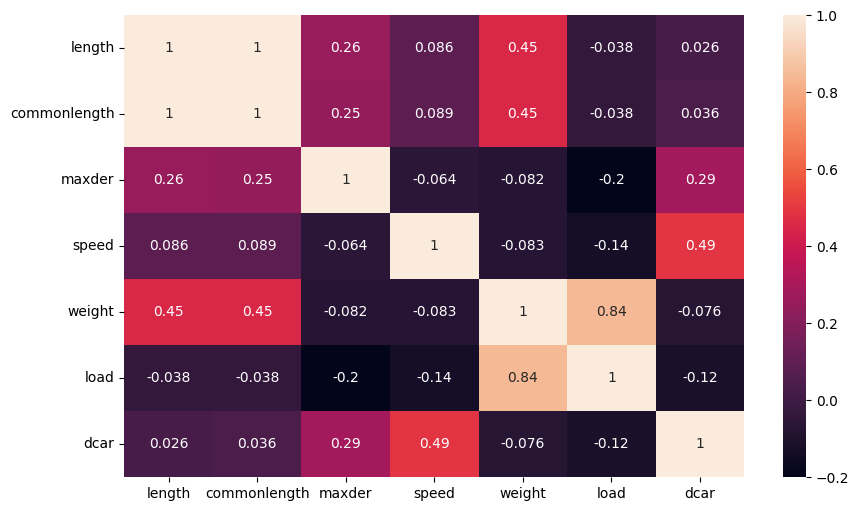

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr = df[['length', 'commonlength', 'maxder', 'speed', 'weight',
       'load', 'dcar']].corr()
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

Напишем метод, который будет применять метод квантильной регрессии `QuantileRegressor` из библиотеки `sklearn.linear_model`. Метод заключается заключается минимизации функции:

$$ F(\beta) = \sum\limits_{y_k \geq f(x_k, \beta)}(\alpha\left| y_k-f(x_k, \beta) \right|) + \sum\limits_{y_k < f(x_k, \beta)}((1-\alpha)\left| y_k-f(x_k, \beta) \right|) \rightarrow \min_{\beta}, $$
где $y_k, k=1,\dots,n$ - набор скалярных экспериментальных данных, интересующий нас столбец таблицы `dcar`, $x_k$ - набор векторных экспериментальных данных и предполагается, что $y$ зависит от $x$. $f(x, \beta)$ - скалярная функция, которая определяется вектором неизвестных параметров $\beta$.

In [45]:
def solve(df, quantile=0.5):
    y = df['dcar']
    X = df.drop(['dcar'], axis=1)
    model = QuantileRegressor(quantile=quantile, alpha=0)
    model.fit(X, y)
    y_pred = model.predict(X)

    n = X.shape[0]
    p = X.shape[1]
    
    y_np = y.to_numpy()
    r2 = 1 - sum([(y_np[i] - y_pred[i])**2 for i in range(len(y_np))])/sum([(y_np[i] - np.mean(y_np))**2 for i in range(len(y))])
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    mae = mean_absolute_error(y, y_pred)
    mre = np.mean([abs((true - pred)/true) if true != 0 else 0 
                for true, pred in zip(y, y_pred)])
    error_variance = sum((y[i]-y_pred[i])**2 for i in range(len(y)))/(n-df.shape[1])
    

    return {
        'names': model.feature_names_in_,
        'intercept': model.intercept_,
        'params': model.coef_,
        'quantile': quantile,
        'y': y.to_numpy(),
        'y_pred': y_pred,
        'r2': r2,
        'adj_r2': adj_r2,
        'mae': mae,
        'mre': mre,
        'error_variance': error_variance
    }

Разберем различные варианты набора столбцов $x$. Исключим из рассмотрения столбцы с большим количеством пропусков, а именно `curve` и `profile`. Столбец `type` также не рассматривается, так как не несет никакой полезной информации.

In [88]:
data = {
    'Зависимость': [],
    'Уровень': [],
    'R^2_adj': [],
    'Δ': [],
    '𝛿': [],
    '𝜎̂^2': []
}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

result_table = pd.DataFrame(data)

In [89]:
# Тест 1.

dd = df[['speed', 'dcar']].copy().dropna()
res_1 = solve(dd, quantile=0.25)
ans_1 = "dcar = "
for i in range(len(res_1['params'])):
    ans_1 += f"{res_1['params'][i]:.4f}*{res_1['names'][i]} + "
ans_1 += str(format(res_1['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_1, res_1['quantile'], res_1['adj_r2'], res_1['mae'], res_1['mre'], res_1['error_variance']]
res_1

{'names': array(['speed'], dtype=object),
 'intercept': 0.8305084745762712,
 'params': array([0.01694915]),
 'quantile': 0.25,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([0.93220339, 1.33898305, 1.        , 1.3220339 , 0.91525424,
        1.25423729, 2.        , 1.        , 1.15254237, 1.22033898,
        0.89830508, 1.10169492, 1.96610169, 1.18644068, 0.86440678,
        0.98305085, 1.11864407, 1.3220339 , 1.        , 1.10169492,
        2.01694915, 1.27118644, 1.18644068, 1.05084746, 1.13559322,
        1.15254237, 1.01694915, 1.10169492, 1.45762712, 1.06779661,
        1.06779661, 1.06779661, 1.08474576, 1.15254237, 1.91525424,
        0.91525424, 1.11864407, 1.15254237, 1.08474576, 1.06779661]),
 'r2': -0.24345474378982757,
 'adj_r2': -0.27617723704745467,
 'mae': 2.1529661016949158,
 'mre': 0.4296864223347

In [90]:
# Тест 2

dd = df[['speed', 'dcar']].copy().dropna()
res_2 = solve(dd, quantile=0.5)
ans_2 = "dcar = "
for i in range(len(res_2['params'])):
    ans_2 += f"{res_2['params'][i]:.4f}*{res_2['names'][i]} + "
ans_2 += str(format(res_2['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_2, res_2['quantile'], res_2['adj_r2'], res_2['mae'], res_2['mre'], res_2['error_variance']]
res_2

{'names': array(['speed'], dtype=object),
 'intercept': 0.6923076923076923,
 'params': array([0.07692308]),
 'quantile': 0.5,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([1.15384615, 3.        , 1.46153846, 2.92307692, 1.07692308,
        2.61538462, 6.        , 1.46153846, 2.15384615, 2.46153846,
        1.        , 1.92307692, 5.84615385, 2.30769231, 0.84615385,
        1.38461538, 2.        , 2.92307692, 1.46153846, 1.92307692,
        6.07692308, 2.69230769, 2.30769231, 1.69230769, 2.07692308,
        2.15384615, 1.53846154, 1.92307692, 3.53846154, 1.76923077,
        1.76923077, 1.76923077, 1.84615385, 2.15384615, 5.61538462,
        1.07692308, 2.        , 2.15384615, 1.84615385, 1.76923077]),
 'r2': 0.15902845912914632,
 'adj_r2': 0.13689762910622905,
 'mae': 1.932692307692308,
 'mre': 0.6103273115773116,

In [91]:
# Тест 3

dd = df[['speed', 'dcar']].copy().dropna()
res_3 = solve(dd, quantile=0.75)
ans_3 = "dcar = "
for i in range(len(res_3['params'])):
    ans_3 += f"{res_3['params'][i]:.4f}*{res_3['names'][i]} + "
ans_3 += str(format(res_3['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_3, res_3['quantile'], res_3['adj_r2'], res_3['mae'], res_3['mre'], res_3['error_variance']]
res_3

{'names': array(['speed'], dtype=object),
 'intercept': 1.3333333333333344,
 'params': array([0.16666667]),
 'quantile': 0.75,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 2.33333333,  6.33333333,  3.        ,  6.16666667,  2.16666667,
         5.5       , 12.83333333,  3.        ,  4.5       ,  5.16666667,
         2.        ,  4.        , 12.5       ,  4.83333333,  1.66666667,
         2.83333333,  4.16666667,  6.16666667,  3.        ,  4.        ,
        13.        ,  5.66666667,  4.83333333,  3.5       ,  4.33333333,
         4.5       ,  3.16666667,  4.        ,  7.5       ,  3.66666667,
         3.66666667,  3.66666667,  3.83333333,  4.5       , 12.        ,
         2.16666667,  4.16666667,  4.5       ,  3.83333333,  3.66666667]),
 'r2': -0.02732108438888603,
 'adj_r2': -0.05435584976754093,
 'mae': 2.7

In [92]:
# Тест 4

dd = df[['speed', 'maxder', 'dcar']].copy().dropna()
res_4 = solve(dd, quantile=0.25)
ans_4 = "dcar = "
for i in range(len(res_4['params'])):
    ans_4 += f"{res_4['params'][i]:.4f}*{res_4['names'][i]} + "
ans_4 += str(format(res_4['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_4, res_4['quantile'], res_4['adj_r2'], res_4['mae'], res_4['mre'], res_4['error_variance']]
res_4

{'names': array(['speed', 'maxder'], dtype=object),
 'intercept': 0.6943947525342874,
 'params': array([0.01759094, 0.00327967]),
 'quantile': 0.25,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([1.        , 1.22868217, 1.08348241, 1.34883721, 0.85778175,
        1.32766846, 2.        , 0.90310078, 1.13029219, 1.43023256,
        0.76803816, 1.15623137, 1.89266547, 1.1523554 , 0.81156828,
        1.01341682, 1.        , 1.33243888, 0.95557543, 1.12015504,
        2.16845558, 1.21735242, 1.10644007, 1.16577221, 1.07662493,
        1.13357185, 0.89773405, 1.17918903, 1.34853906, 1.03577818,
        1.12104949, 1.08497317, 1.11568277, 1.14341085, 1.83005367,
        0.78890877, 1.03279666, 1.18932618, 1.1320811 , 1.03905784]),
 'r2': -0.23230455754453927,
 'adj_r2': -0.298915614709109,
 'mae': 2.153361657722123,
 'mr

In [93]:
# Тест 5

dd = df[['speed', 'maxder', 'dcar']].copy().dropna()
res_5 = solve(dd, quantile=0.5)
ans_5 = "dcar = "
for i in range(len(res_5['params'])):
    ans_5 += f"{res_5['params'][i]:.4f}*{res_5['names'][i]} + "
ans_5 += str(format(res_5['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_5, res_5['quantile'], res_5['adj_r2'], res_5['mae'], res_5['mre'], res_5['error_variance']]
res_5

{'names': array(['speed', 'maxder'], dtype=object),
 'intercept': 0.7715019255455713,
 'params': array([0.03337612, 0.03080873]),
 'quantile': 0.5,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([2.85109114, 1.83440308, 3.10783055, 3.09499358, 1.64698331,
        3.42362003, 3.93709884, 1.41335045, 2.36071887, 4.6508344 ,
        0.93581515, 3.        , 3.19255456, 2.3042362 , 1.6084724 ,
        2.58151476, 1.40051348, 2.94094994, 1.90629012, 2.66110398,
        5.38767651, 2.25545571, 1.87291399, 3.48523748, 1.98844673,
        2.3915276 , 1.23106547, 3.2156611 , 2.03722721, 2.1322208 ,
        2.93324775, 2.59435173, 2.75096277, 2.48395379, 3.        ,
        1.        , 1.70860077, 2.91527599, 2.90500642, 2.16302953]),
 'r2': 0.16660337118756918,
 'adj_r2': 0.12155490476527553,
 'mae': 1.9057445442875482,
 'mr

In [94]:
# Тест 6

dd = df[['speed', 'maxder', 'dcar']].copy().dropna()
res_6 = solve(dd, quantile=0.75)
ans_6 = "dcar = "
for i in range(len(res_6['params'])):
    ans_6 += f"{res_6['params'][i]:.4f}*{res_6['names'][i]} + "
ans_6 += str(format(res_6['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_6, res_6['quantile'], res_6['adj_r2'], res_6['mae'], res_6['mre'], res_6['error_variance']]
res_6

{'names': array(['speed', 'maxder'], dtype=object),
 'intercept': 0.6002506265664158,
 'params': array([0.09022556, 0.03884712]),
 'quantile': 0.75,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([3.5112782 , 3.38471178, 4.02756892, 4.92606516, 1.94486216,
        5.14786967, 7.91353383, 1.89097744, 3.51879699, 6.59899749,
        1.        , 4.18045113, 6.87844612, 3.54385965, 1.7518797 ,
        3.31578947, 2.21177945, 4.73182957, 2.51253133, 3.75313283,
        9.79072682, 3.72305764, 3.        , 4.64786967, 3.00125313,
        3.55764411, 1.70927318, 4.45238095, 3.97744361, 2.98997494,
        4.        , 3.5726817 , 3.81829574, 3.67418546, 6.49122807,
        1.12907268, 2.60025063, 4.21804511, 4.01253133, 3.02882206]),
 'r2': 0.3065424616313229,
 'adj_r2': 0.2690582703681511,
 'mae': 2.142324561403508,
 'mre'

In [95]:
# Тест 7

dd = df[['length', 'commonlength', 'maxder', 'dcar', 'speed', 'weight', 'load']].copy()
res_7 = solve(dd, quantile=0.25)
ans_7 = "dcar = "
for i in range(len(res_7['params'])):
    ans_7 += f"{res_7['params'][i]:.4f}*{res_7['names'][i]} + "
ans_7 += str(format(res_7['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_7, res_7['quantile'], res_7['adj_r2'], res_7['mae'], res_7['mre'], res_7['error_variance']]
res_7

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load'],
       dtype=object),
 'intercept': 2.3087477297676027,
 'params': array([-9.91892948e-02,  5.85935924e-02,  2.99383809e-03,  1.95596779e-02,
         6.08573653e-04, -2.68091010e+00]),
 'quantile': 0.25,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([1.04037015, 1.        , 0.95680453, 1.51919087, 0.87811911,
        1.41767496, 2.        , 1.        , 1.33852229, 0.53329676,
        0.78447688, 1.2327608 , 2.07407935, 1.20819441, 0.8809573 ,
        1.        , 1.        , 1.7150064 , 1.10902092, 1.23953884,
        2.27435638, 1.87954351, 1.69425394, 1.4620949 , 1.27489675,
        1.991445  , 0.77206153, 1.3481938 , 1.16170884, 1.00570775,
        1.1869186 , 1.05774515, 0.93787782, 1.24666587, 2.01804777,
        1.        , 2.  

In [96]:
# Тест 8

dd = df[['length', 'commonlength', 'maxder', 'dcar', 'speed', 'weight', 'load']].copy()
res_8 = solve(dd, quantile=0.5)
ans_8 = "dcar = "
for i in range(len(res_8['params'])):
    ans_8 += f"{res_8['params'][i]:.4f}*{res_8['names'][i]} + "
ans_8 += str(format(res_8['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_8, res_8['quantile'], res_8['adj_r2'], res_8['mae'], res_8['mre'], res_8['error_variance']]
res_8

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load'],
       dtype=object),
 'intercept': 1.7620644603865607,
 'params': array([-3.38813048e-01,  2.69381522e-01,  2.59937552e-02,  3.02993111e-02,
         1.42246554e-03, -4.90374271e+00]),
 'quantile': 0.5,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([2.82099787, 1.        , 1.74292291, 2.47626121, 1.18444322,
        2.88185467, 2.56840612, 1.        , 3.30120958, 2.        ,
        0.93710295, 3.30937272, 3.57771232, 2.26338635, 2.        ,
        2.5767578 , 0.84712195, 2.71664315, 2.08160226, 1.97015596,
        4.33236682, 4.97150895, 1.33951697, 4.69250249, 3.        ,
        2.46574629, 1.08656239, 4.        , 2.12063234, 2.23032354,
        2.98893464, 2.05780065, 2.        , 2.35110355, 3.50391635,
        2.28913891, 2.219

In [97]:
# Тест 9

dd = df[['length', 'commonlength', 'maxder', 'dcar', 'speed', 'weight', 'load']].copy()
res_9 = solve(dd, quantile=0.75)
ans_9 = "dcar = "
for i in range(len(res_9['params'])):
    ans_9 += f"{res_9['params'][i]:.4f}*{res_9['names'][i]} + "
ans_9 += str(format(res_9['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_9, res_9['quantile'], res_9['adj_r2'], res_9['mae'], res_9['mre'], res_9['error_variance']]
res_9

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load'],
       dtype=object),
 'intercept': 2.4520172083482077,
 'params': array([-1.24202000e+00,  1.10595574e+00,  5.05221076e-02,  8.26979211e-02,
         2.33777932e-03, -9.64431488e+00]),
 'quantile': 0.75,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 3.58057275,  1.        ,  3.03054034,  4.4610281 ,  2.01974154,
         4.79135151,  6.04005867,  1.07014293,  5.53862332,  3.50310326,
         0.17157923,  4.41565228,  6.        ,  3.        ,  1.6242772 ,
         2.97833623,  2.58112466,  6.59399024,  4.03718466,  3.16350864,
        10.65800297,  7.        ,  3.        ,  7.01320125,  4.86945945,
         5.04021906,  1.03057808,  5.17851103,  3.32942561,  3.08332262,
         4.        ,  3.50627264,  2.49282502,  4.79912679,  6

In [98]:
# Тест 10

dd = df[['length', 'commonlength', 'maxder', 'dcar', 'speed', 'weight', 'load']].copy()
dd['weight/load'] = dd['weight']/dd['load']
res_10 = solve(dd, quantile=0.25)
ans_10 = "dcar = "
for i in range(len(res_10['params'])):
    ans_10 += f"{res_10['params'][i]:.4f}*{res_10['names'][i]} + "
ans_10 += str(format(res_10['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_10, res_10['quantile'], res_10['adj_r2'], res_10['mae'], res_10['mre'], res_10['error_variance']]
res_10

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load',
        'weight/load'], dtype=object),
 'intercept': 2.3199974431176407,
 'params': array([-1.00857082e-01,  5.99686181e-02,  3.03591870e-03,  1.96182484e-02,
         6.11204527e-04, -2.69450349e+00, -1.73428582e-08]),
 'quantile': 0.25,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([1.04049377, 1.        , 0.95496545, 1.52239524, 0.87849224,
        1.42032029, 2.        , 1.        , 1.34071453, 0.52554645,
        0.78188257, 1.23168537, 2.0752603 , 1.20751786, 0.87911479,
        1.        , 1.        , 1.72146206, 1.11142797, 1.24303575,
        2.27897354, 1.87875233, 1.70280712, 1.4636529 , 1.27654181,
        2.        , 0.77197522, 1.34839397, 1.15729221, 1.00660199,
        1.18720314, 1.06104387, 0.93895385, 1.25139385, 2.0

In [99]:
# Тест 11

dd = df[['length', 'commonlength', 'maxder', 'dcar', 'speed', 'weight', 'load']].copy()
dd['weight/load'] = dd['weight']/dd['load']
res_11 = solve(dd, quantile=0.5)
ans_11 = "dcar = "
for i in range(len(res_11['params'])):
    ans_11 += f"{res_11['params'][i]:.4f}*{res_11['names'][i]} + "
ans_11 += str(format(res_11['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_11, res_11['quantile'], res_11['adj_r2'], res_11['mae'], res_11['mre'], res_11['error_variance']]
res_11

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load',
        'weight/load'], dtype=object),
 'intercept': 3.515134846928383,
 'params': array([-4.58715266e-01,  3.45188696e-01,  3.90998833e-02,  7.49786157e-02,
         1.88125611e-03, -8.07967323e+00, -3.75241991e-06]),
 'quantile': 0.5,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([2.76429386, 1.        , 1.96271896, 3.85175774, 1.15357649,
        4.        , 4.92661879, 1.        , 3.33813874, 2.        ,
        0.13931391, 3.47917713, 5.23257464, 2.49649583, 1.17434684,
        2.28409256, 1.        , 4.52017769, 2.22341059, 2.69582882,
        7.46255921, 4.98278872, 2.84608331, 4.89488219, 2.7974514 ,
        4.42007049, 0.28668578, 4.        , 2.30015067, 1.89776555,
        3.16442986, 2.3318471 , 2.        , 2.8939173 , 5.057

In [100]:
# Тест 12

dd = df[['length', 'commonlength', 'maxder', 'dcar', 'speed', 'weight', 'load']].copy()
dd['weight/load'] = dd['weight']/dd['load']
res_12 = solve(dd, quantile=0.75)
ans_12 = "dcar = "
for i in range(len(res_12['params'])):
    ans_12 += f"{res_12['params'][i]:.4f}*{res_12['names'][i]} + "
ans_12 += str(format(res_12['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_12, res_12['quantile'], res_12['adj_r2'], res_12['mae'], res_12['mre'], res_12['error_variance']]
res_12

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load',
        'weight/load'], dtype=object),
 'intercept': 2.4503560169652925,
 'params': array([-1.24248858e+00,  1.10727371e+00,  5.05074907e-02,  8.27082151e-02,
         2.33421881e-03, -9.64495826e+00, -5.82697329e-06]),
 'quantile': 0.75,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([3.58041048, 1.        , 2.11206567, 4.45576671, 1.99842279,
        4.79011958, 5.10265064, 1.06434409, 5.54073445, 2.17922175,
        0.17113322, 4.41562077, 6.        , 3.        , 1.62443809,
        2.97755826, 2.19419835, 6.50737318, 4.03716809, 3.16312873,
        9.67972768, 7.        , 3.        , 7.01306455, 4.87136333,
        4.97773077, 1.0314992 , 5.17612388, 3.32594607, 3.08381221,
        4.        , 3.50762434, 2.4921945 , 4.80206603, 6.4

In [101]:
# Тест 13
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'dcar']].copy().dropna()
dd['speed2'] = dd['speed']**2
dd['maxder3'] = dd['maxder']**3
dd = dd.drop(['weight'], axis=1)
res_13 = solve(dd, quantile=0.25)
ans_13 = "dcar = "
for i in range(len(res_13['params'])):
    ans_13 += f"{res_13['params'][i]:.4f}*{res_13['names'][i]} + "
ans_13 += str(format(res_13['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_13, res_13['quantile'], res_13['adj_r2'], res_13['mae'], res_13['mre'], res_13['error_variance']]
res_13

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'load', 'speed2',
        'maxder3'], dtype=object),
 'intercept': 1.3840535167049364,
 'params': array([-5.28795081e-02,  4.50918445e-02,  7.48419500e-04,  4.81017323e-03,
        -2.30265783e-01,  1.46620333e-04,  1.01233711e-06]),
 'quantile': 0.25,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([1.09175885, 1.18694793, 1.31623651, 1.33887144, 1.        ,
        1.36034139, 2.        , 0.99897954, 1.02821758, 2.        ,
        0.82743653, 1.00561604, 1.72273739, 0.98982483, 0.79406401,
        1.        , 1.13188364, 1.4645616 , 1.05689052, 1.24482063,
        2.5378972 , 0.78361919, 1.473972  , 1.24151679, 0.98423937,
        1.42134641, 0.97671559, 1.07687975, 1.        , 1.        ,
        1.0772548 , 1.20897881, 1.14148251, 1.25129219, 1.71470

In [102]:
# Тест 14
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'dcar']].copy().dropna()
dd['speed2'] = dd['speed']**2
dd['maxder3'] = dd['maxder']**3
dd = dd.drop(['weight'], axis=1)
res_14 = solve(dd, quantile=0.5)
ans_14 = "dcar = "
for i in range(len(res_14['params'])):
    ans_14 += f"{res_14['params'][i]:.4f}*{res_14['names'][i]} + "
ans_14 += str(format(res_14['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_14, res_14['quantile'], res_14['adj_r2'], res_14['mae'], res_14['mre'], res_14['error_variance']]
res_14

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'load', 'speed2',
        'maxder3'], dtype=object),
 'intercept': 0.3611867288451994,
 'params': array([-5.65220015e-01,  5.42536947e-01,  6.79091769e-02, -3.08193687e-02,
         6.62516392e-01,  1.56456822e-03, -4.03971359e-06]),
 'quantile': 0.5,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([3.46825924, 1.75249817, 3.01798317, 3.47563202, 1.97939701,
        3.83291541, 7.00004274, 0.8366318 , 3.6310235 , 2.        ,
        0.18487787, 3.        , 6.        , 2.02758625, 2.        ,
        3.41390381, 1.        , 4.13738558, 2.89143067, 3.3910765 ,
        9.84701094, 2.07055237, 2.37881448, 4.11402003, 3.        ,
        2.80021479, 1.60434324, 3.74538041, 1.        , 3.15902353,
        3.3399105 , 4.03615863, 3.71505553, 4.1564931 , 5.890963

In [103]:
# Тест 15
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'dcar']].copy().dropna()
dd['maxder3'] = dd['maxder']**3
res_15 = solve(dd, quantile=0.75)
ans_15 = "dcar = "
for i in range(len(res_15['params'])):
    ans_15 += f"{res_15['params'][i]:.4f}*{res_15['names'][i]} + "
ans_15 += str(format(res_15['intercept'], '.4f'))
result_table.loc[len(result_table)] = [ans_15, res_15['quantile'], res_15['adj_r2'], res_15['mae'], res_15['mre'], res_15['error_variance']]
res_15

{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load',
        'maxder3'], dtype=object),
 'intercept': 1.3719989604920284,
 'params': array([-9.70249469e-01,  8.72110032e-01,  7.79648882e-02,  9.57224299e-02,
         1.63410719e-03, -7.38917011e+00, -5.02289132e-06]),
 'quantile': 0.75,
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 3.38479179,  1.        ,  3.52790592,  5.12448425,  2.13805577,
         5.12610294,  7.55987318,  1.        ,  5.        ,  2.        ,
        -0.39060354,  4.37731653,  6.        ,  3.20065127,  1.31834214,
         2.98325669,  2.35829723,  6.91426487,  3.79389922,  3.63181815,
        11.06085841,  5.69381999,  3.        ,  5.60646321,  4.10605676,
         5.16958056,  0.41381239,  4.60197963,  3.14396409,  2.93207719,
         4.        ,  3.73762857,

In [108]:
styled_results = result_table.style \
    .format("{:.4f}", subset=["R^2_adj"]) \
    .format("{:.4f}", subset=["Δ"]) \
    .format("{:.4f}", subset=["𝛿"]) \
    .format("{:.4f}", subset=["𝜎̂^2"]) \
    .highlight_max(color="grey", subset=["R^2_adj"])  

styled_results

,Зависимость,Уровень,R^2_adj,Δ,𝛿,𝜎̂^2
0,dcar = 0.0169*speed + 0.8305,0.250000,-0.2762,2.1530,0.4297,18.0620
1,dcar = 0.0769*speed + 0.6923,0.500000,0.1369,1.9327,0.6103,12.2157
2,dcar = 0.1667*speed + 1.3333,0.750000,-0.0544,2.7917,1.5485,14.9225
3,dcar = 0.0176*speed + 0.0033*maxder + 0.6944,0.250000,-0.2989,2.1534,0.4328,18.3838
4,dcar = 0.0334*speed + 0.0308*maxder + 0.7715,0.500000,0.1216,1.9057,0.6853,12.4328
5,dcar = 0.0902*speed + 0.0388*maxder + 0.6003,0.750000,0.2691,2.1423,1.0955,10.3452
6,dcar = -0.0992*length + 0.0586*commonlength + 0.0030*maxder + 0.0196*speed + 0.0006*weight + -2.6809*load + 2.3087,0.250000,-0.4069,2.0578,0.4070,19.9117
7,dcar = -0.3388*length + 0.2694*commonlength + 0.0260*maxder + 0.0303*speed + 0.0014*weight + -4.9037*load + 1.7621,0.500000,-0.0353,1.7053,0.5605,14.6525
8,dcar = -1.2420*length + 1.1060*commonlength + 0.0505*maxder + 0.0827*speed + 0.0023*weight + -9.6443*load + 2.4520,0.750000,0.2279,2.0245,1.0637,10.9280
9,dcar = -0.1009*length + 0.0600*commonlength + 0.0030*maxder + 0.0196*speed + 0.0006*weight + -2.6945*load + -0.0000*weight/load + 2.3200,0.250000,-0.4500,2.0571,0.4071,20.5228


Для шестого набора столбцов $x$ и квантильной регрессии $0.75$ была построена наилучшая оценка, если судить по значению скорректированного коэффициента детерминации. Разобьем данные на обучающую и тестовую выборки, обучим модель и проверим, насколько она точна.

In [ ]:
def predict_dcar(df, quantile=0.5):
    X = df.drop('dcar', axis=1)
    y = df['dcar']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = QuantileRegressor(quantile=quantile, alpha=0)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    n_train = X_train.shape[0]
    p_train = X_train.shape[1]
    r2_train = model.score(X_train, y_train)
    adj_r2_train = 1 - (1-r2_train)*(n_train-1)/(n_train-p_train-1)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mre_train = np.mean([abs((true - pred)/true) if true != 0 else 0 
                for true, pred in zip(y_train, y_train_pred)])
    error_variance_train = np.var(y_train - y_train_pred, ddof=p_train+1)
    y_test_pred = model.predict(X_test)
    n_test = X_test.shape[0]
    p_test = X_test.shape[1]
    r2_test = model.score(X_test, y_test)
    adj_r2_test = 1 - (1-r2_test)*(n_test-1)/(n_test-p_test-1)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mre_test = np.mean([abs((true - pred)/true) if true != 0 else 0 
                for true, pred in zip(y_test, y_test_pred)])
    error_variance_test = np.var(y_test - y_test_pred, ddof=p_test+1)
    
    return {
        'params': model.coef_,
        'y_train': y_train.to_numpy(),
        'y_train_pred': y_train_pred,
        'y_test': y_test.to_numpy(),
        'y_test_pred': y_test_pred,
        'r2_train': r2_train,
        'adj_r2_train': adj_r2_train,
        'mae_train': mae_train,
        'mre_train': mre_train,
        'error_variance_train': error_variance_train,
        'r2_test': r2_test,
        'adj_r2_test': adj_r2_test,
        'mae_test': mae_test,
        'mre_test': mre_test,
        'error_variance_test': error_variance_test
    }

In [110]:
dd = df[['speed', 'maxder', 'dcar']].copy().dropna()
res = predict_dcar(dd, quantile=0.75)
res

{'params': array([0.16770186, 0.05175983]),
 'y_train': array([ 2,  1, 22,  1,  1,  2, 10,  3,  1,  4,  4,  2,  1,  4,  6,  2,  1,
         4,  3,  7,  1,  2,  1,  1,  1,  3,  1,  1], dtype=int64),
 'y_train_pred': array([11.82608696,  2.65424431, 14.3747412 ,  4.81573499,  2.85093168,
         0.43478261,  5.94616977,  3.        ,  5.0621118 ,  4.69772257,
         6.05175983,  3.80538302,  1.        ,  3.84679089, 10.35196687,
         7.89026915,  0.83436853,  4.        ,  3.72463768,  4.20082816,
         3.80331263,  2.27743271,  2.9689441 ,  4.06418219,  3.76604555,
         4.33540373,  1.75983437,  2.70600414]),
 'y_test': array([9, 1, 3, 3, 3, 1, 1, 5, 6, 2, 2, 3], dtype=int64),
 'y_test_pred': array([ 3.43064182,  3.93995859,  1.82815735,  0.80538302,  2.85921325,
        -0.47204969, -0.25258799,  3.59627329,  4.52795031,  5.6873706 ,
         3.64803313,  9.69358178]),
 'r2_train': 0.35691307894591007,
 'adj_r2_train': 0.3054661252615829,
 'mae_train': 2.4205116829340434,
 

### Заключение

Для рассматриваемых входных данных была применена модель квантильной регрессии для прогнозирования количества подвижных единиц грузового поезда, сошедших с рельсов. Наилучшим образом показала себя модель с параметрами `speed` и `maxder`. Скорректированный коэффициент детерминации $R^2_{adj}$ в случае обучения модели на всех данных равен $0.2691$. После разделения выборки на обучающую и тестовую результат на обучающей выборке улучшился - $R^2_{adj} = 0.3055$, на тестовой, наоборот, ухудшился - $R^2_{adj} = -0.8451$. Это может быть связано с тем, что модель переобучилась на обучающей выборке.